In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Downloading the data from website
import urllib.request

# target->the url adress of the file that we are going to download / fn -> the local filename that is stored
target = 'https://hastie.su.domains/ElemStatLearn/datasets/LAozone.data'
fn = 'oz.dat'
urllib.request.urlretrieve(target,fn)

# Download the text from file fn: unpack=True->need to decompress the file / delimiter=','->the file use , as seperate sign / skiprows=1->need to skip the first row
oz, vh, wind, humidity, temp_faren, ibh, dpg, ibt, vis, doy = np.loadtxt(fn,unpack=True, delimiter=',', skiprows=1)

# Transforming the temperature degree from Fahrenheit to Celsius
temp = (temp_faren-32)*5/9

## 1. Data Processing

### 1.1 Sorting outliers

In [3]:
# Sort Outliers: by deleting the data >mean+3 standard deviation and <mean-3 standard deviation
def sort_outlier(X):
    
    # Calculate standard deviation and mean
    X_std = np.std(X)
    X_mu = np.mean(X)
    
    # Transfrom our data into normal distribution
    X_norm_dist = np.e**(-0.5*((X-X_mu)/X_std)**2)/(X_std*np.sqrt(2*np.pi))
    
    # Calculate new standard deviation and mean for the normal distribution
    std = np.std(X_norm_dist)
    mu = np.mean(X_norm_dist)
    
    # Check if there are any extreme values and add it into outliers: data outside the range mean+-3std
    outliers = []
    for i in range(len(X)):
        if X_norm_dist[i] < mu - std*3 or X_norm_dist[i] > mu + std*3:
            outliers.append(i)
    return outliers

# Print the index of the outliers
variables = [oz, vh, wind, humidity, temp, ibh, dpg, ibt, vis]
variables_name = ['oz', 'vh', 'wind', 'humidity', 'temp', 'ibh', 'dpg', 'ibt', 'vis']
for i in range(len(variables)):
    print(f'{variables_name[i]}: {sort_outlier(variables[i])}')

oz: []
vh: []
wind: []
humidity: []
temp: []
ibh: []
dpg: []
ibt: []
vis: []


### 1.2 To proceed regression, we should check if variables are correlated

### 1.2.1 
### Method 1. Check their correlation value

In [4]:
# Define function Corr(x,y) to calculate the correlation between two variables
def Corr(x,y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_std = np.std(x)
    y_std = np.std(y)
    corr = np.mean((x-x_mean)*(y-y_mean))/(x_std*y_std)
    return corr

# Create lists to store pairs of variables: 
# ignore : corr < 0.3
# weak : 0.3 <= corr < 0.5
# medium : 0.5 <= corr < 0.7
# strong : 0.7 <= corr < 1.0 

ignore=[]
ignore_list=[]
weak_corr=[]
weak_list=[]
med_corr=[]
med_list=[]
strong_corr=[]
strong_list=[]

# Calculate the correlation value between every two variables and put them into the corresponding list 
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        corr_val = np.abs(Corr(variables[i], variables[j]))
        if corr_val < 0.3:
            ignore.append(corr_val)
            ignore_list.append([variables_name[i], variables_name[j]])
        elif 0.3 <= corr_val < 0.5:
            weak_corr.append(corr_val)
            weak_list.append([variables_name[i], variables_name[j]])      
        elif 0.5 <= corr_val < 0.7:
            med_corr.append(corr_val)
            med_list.append([variables_name[i], variables_name[j]])
        elif 0.7 <= corr_val:
            strong_corr.append(corr_val)
            strong_list.append([variables_name[i], variables_name[j]])

print(f'Can be ignored: {len(ignore)}')
for i in range(len(ignore_list)):
    print(f'{ignore_list[i]}: {ignore[i]}')
print('\n')
print(f'Weakly correlated: {len(weak_corr)}')
for i in range(len(weak_list)):
        print(f'{weak_list[i]}: {weak_corr[i]}')
print('\n')    
print(f'Medium correlated: {len(med_corr)}')
for i in range(len(med_list)):
    print(f'{med_list[i]}: {med_corr[i]}')
print('\n')
print(f'Strongly correlated: {len(strong_corr)}')
for i in range(len(strong_list)):
    print(f'{strong_list[i]}: {strong_corr[i]}')
print('\n')

Can be ignored: 16
['oz', 'wind']: 0.013413523796795794
['oz', 'dpg']: 0.21404639412491552
['vh', 'wind']: 0.2436636332153984
['vh', 'humidity']: 0.07448508273101424
['vh', 'dpg']: 0.14807053592935743
['wind', 'humidity']: 0.21029304960977965
['wind', 'temp']: 0.03207040676859352
['wind', 'ibh']: 0.2065964652322994
['wind', 'ibt']: 0.17951744411255954
['wind', 'vis']: 0.14722693981133853
['humidity', 'ibh']: 0.2423276560800051
['humidity', 'ibt']: 0.20364787798143805
['temp', 'dpg']: 0.18924191735509843
['ibh', 'dpg']: 0.03707789647825124
['dpg', 'ibt']: 0.09506020563339472
['dpg', 'vis']: 0.12585472466314368


Weakly correlated: 9
['oz', 'humidity']: 0.44922398988835427
['oz', 'vis']: 0.4409894648745818
['vh', 'vis']: 0.36008024982662395
['wind', 'dpg']: 0.3357469879810618
['humidity', 'temp']: 0.3404742115957956
['humidity', 'vis']: 0.40100845636278537
['temp', 'vis']: 0.38772104447771005
['ibh', 'vis']: 0.3866858184448236
['ibt', 'vis']: 0.4223720132842925


Medium correlated: 5
['o

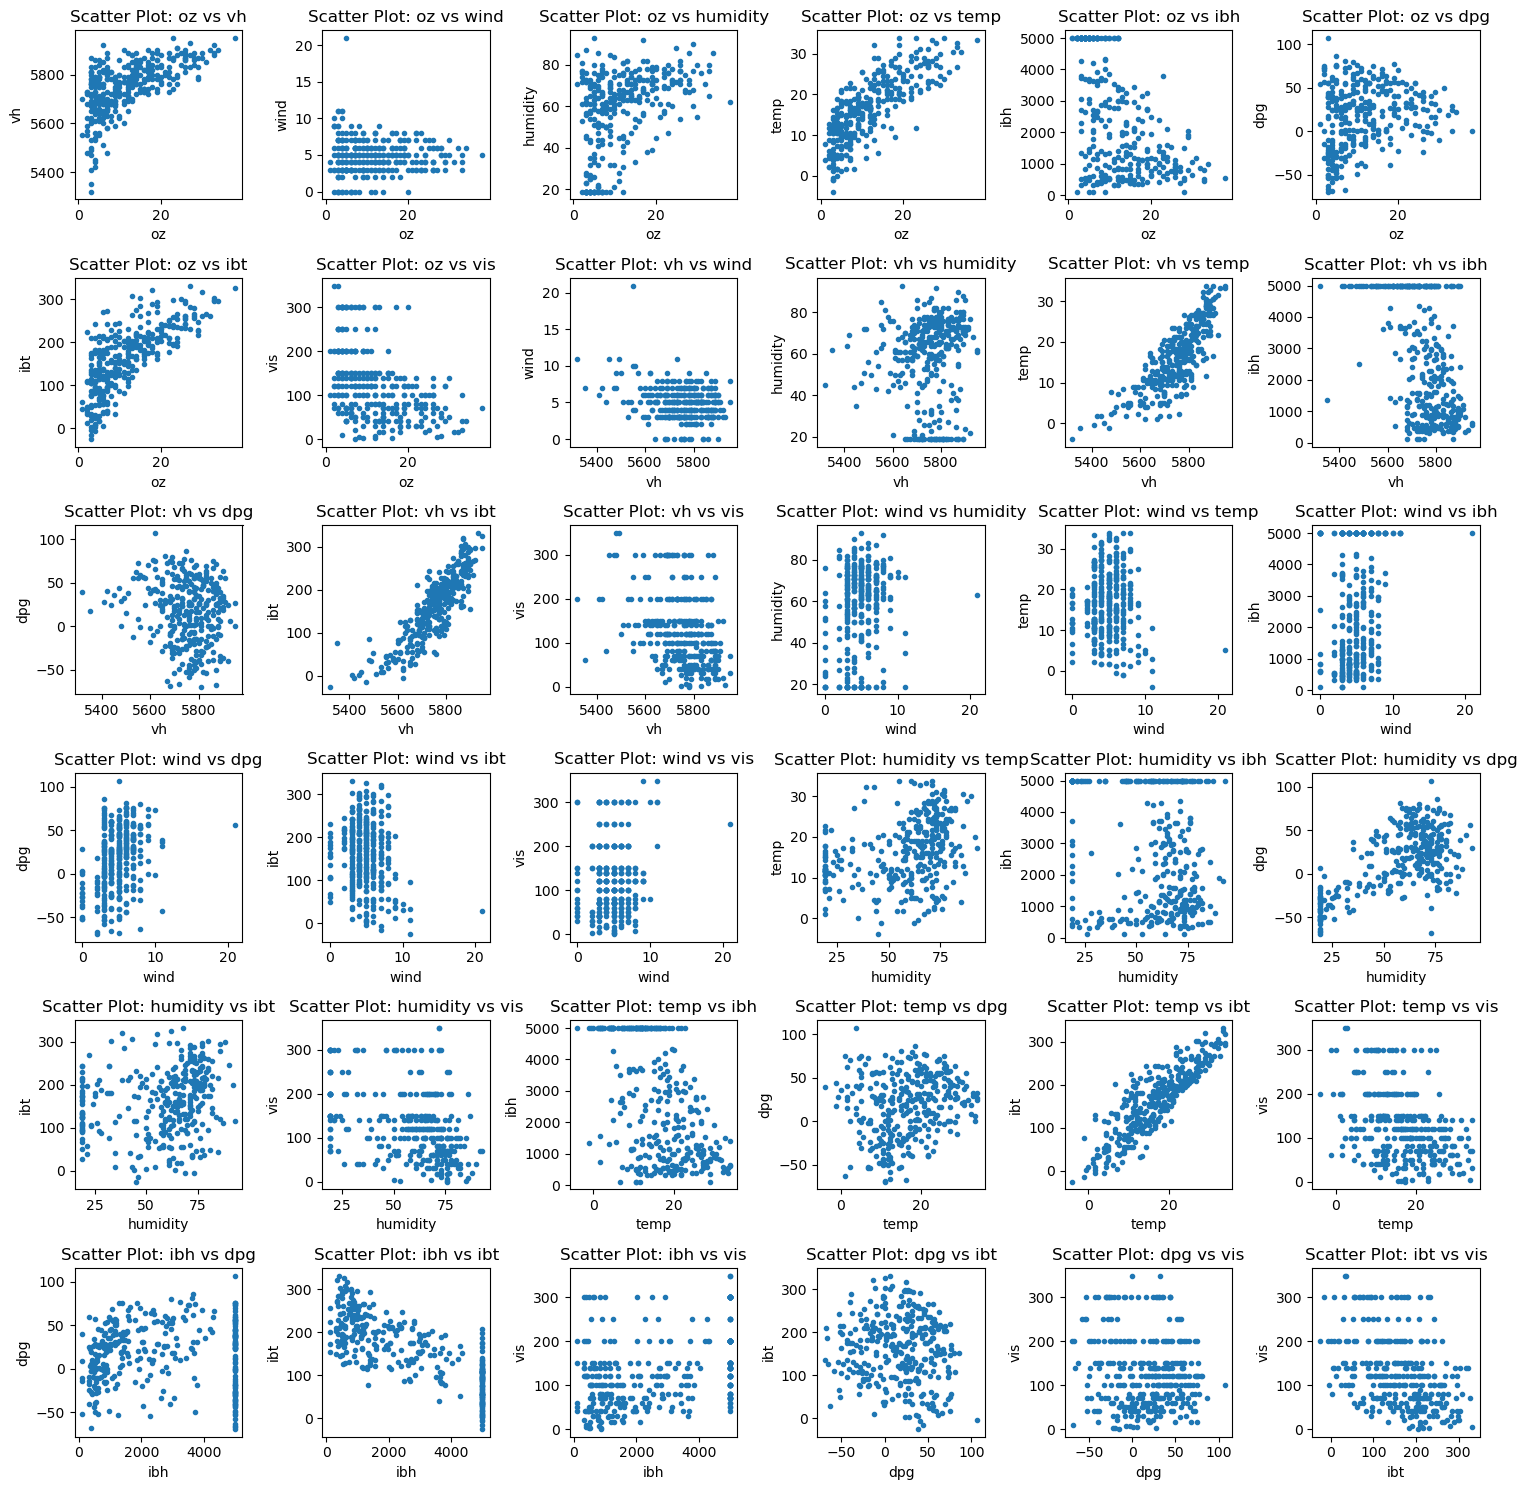

In [5]:
# Plotting the scatter plots to help determine the relationship between variables
from itertools import combinations

# Creating space for subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))
combinations_list = list(combinations(range(len(variables)), 2))

# Plot all the scatter plots into the space
for idx, (i, j) in enumerate(combinations_list):
    row = idx // 6
    col = idx % 6
    x, y = variables[i], variables[j]
    axes[row, col].plot(x, y,'.')
    axes[row, col].set_title(f'Scatter Plot: {variables_name[i]} vs {variables_name[j]}')
    axes[row, col].set_xlabel(variables_name[i])
    axes[row, col].set_ylabel(variables_name[j])

# To make sure the layout of the plots are fine
plt.tight_layout()

### 1.2.2
### Method 2. Check their VIF(variance Inflation Factor) value

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import pandas as pd

data = {
    'wind': wind,
    'humidity': humidity,
    'temp': temp,
    'ibh': ibh,
    'dpg': dpg,
    'vis': vis,
}

# Creating a DataFrame from the data
df = pd.DataFrame(data)

# Adding a constant term to the DataFrame for linear regression
data_frame_with_const = sm.add_constant(df)

# Define function to calculate Variance Inflation Factor
def calculate_vif(data_frame):
    
    # Create a DataFrame for vif_data, store variable names in "Variable" and calculate "VIF" for corresponding variables
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

# Calculating VIF for our DataFrame with the constant term
vif_result = calculate_vif(data_frame_with_const)

print(vif_result)

   Variable        VIF
0     const  40.432918
1      wind   1.217932
2  humidity   2.244617
3      temp   1.559482
4       ibh   1.612055
5       dpg   1.975914
6       vis   1.434881


## 2. Regression

### 2.0 Divide data into training and testing

In [7]:
# Assign an integer to random seed so the outcome of random function will be the same every time
np.random.seed(17)

# Define the whole data size and the size for validation data(about 20%, use as testing data during model selection)
num_samples = 330
num_validation_samples = 65

# Assign another integer to random seed 
np.random.seed(42)

# Create a list of 0-329 in a random permutation
indices = np.random.permutation(num_samples)

#Take the first 65 elements from indices to create validation data and the rest for training data
validation_indices = indices[:num_validation_samples]
train_indices = indices[num_validation_samples:num_samples]

X = np.vstack([wind[train_indices], humidity[train_indices], temp[train_indices], ibh[train_indices], dpg[train_indices], vis[train_indices]]).T
y = oz[train_indices]

X_validation = np.vstack([wind[validation_indices], humidity[validation_indices], temp[validation_indices], ibh[validation_indices], dpg[validation_indices], vis[validation_indices]]).T
y_validation = oz[validation_indices]

### 2.1 Linear Regression

trial: 1:
coefficients: [ 0.02390844  0.06714984  0.57539616 -0.00122362 -0.00419244 -0.00388664]
intercept: 1.9769468195628335
mean squared error: 19.39878654525737
R-squared: 0.628968355719387

trial: 2:
coefficients: [ 0.12823993  0.07333075  0.50699601 -0.00121877 -0.00822819 -0.01002856]
intercept: 3.1338807486710234
mean squared error: 19.73810153947224
R-squared: 0.6671569641586673

trial: 3:
coefficients: [ 0.02489892  0.0792162   0.55221391 -0.00093922  0.00090722 -0.00403358]
intercept: 0.6567389771678069
mean squared error: 23.95281810828878
R-squared: 0.6711816614724556

trial: 4:
coefficients: [-0.05485805  0.06864207  0.55677257 -0.00118813  0.00297225 -0.00702833]
intercept: 2.7678036822152645
mean squared error: 17.71581777903885
R-squared: 0.6616599438318753

trial: 5:
coefficients: [ 0.07870749  0.04005419  0.52227446 -0.0012389   0.01429783 -0.00956064]
intercept: 4.196260581163806
mean squared error: 23.137284645957415
R-squared: 0.6344168987698457



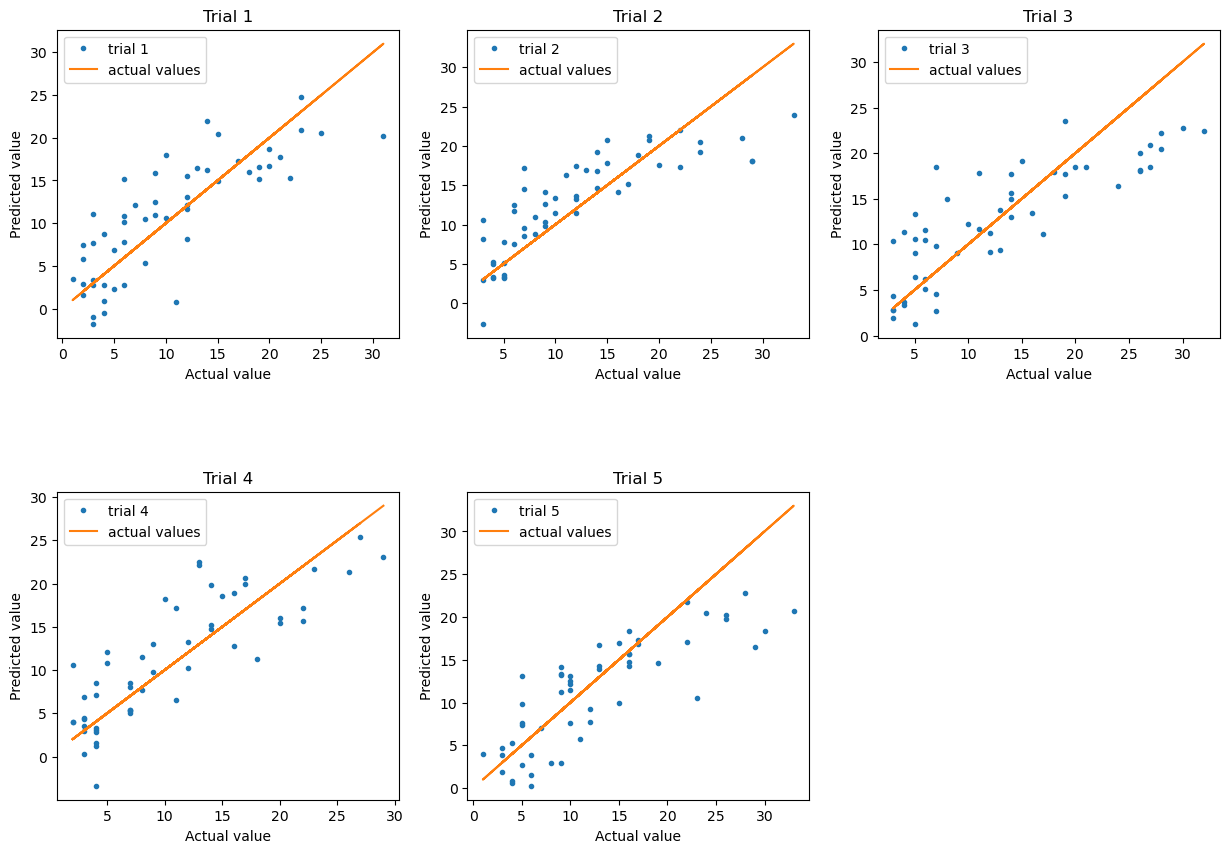

In [8]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Shuffle the data and divide them into 5 parts
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Build up the Linear regression model
model = LinearRegression()

# Creating space for subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Cleaning sum_coeff and sum_intercept before start adding up numbers
sum_coeff = 0
sum_intercept = 0

# Reapeat the model fitting proccess 5 times
i = 0
for train_index, test_index in kf.split(X):
    i+=1

    # In each round take one part(20%) of the data as testing data and the rest as training data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Get the coefficients and intercept of every trial, and also the sum coefficients and intercept of all the trials
    coeff = model.coef_
    sum_coeff = model.coef_ + sum_coeff
    intercept = model.intercept_
    sum_intercept = model.intercept_ + sum_intercept
    mse = mean_squared_error(y_test, model.predict(X_test))
    r2 = r2_score(y_test, model.predict(X_test))
    
    # Plot all the dots and regression line into the plots for every trial 
    row = (i - 1) // 3
    col = (i - 1) % 3
    axs[row, col].plot(y_test, model.predict(X_test), '.', label = f'trial {i}')
    axs[row, col].plot(y_test, y_test, '-', label = 'actual values')
    axs[row, col].set_xlabel('Actual value')
    axs[row, col].set_ylabel('Predicted value')
    axs[row, col].set_title(f'Trial {i}')
    axs[row, col].legend()

    # Print coefficients, intercept, MSE and R2 for every trial 
    print(f'trial: {i}:')
    print(f'coefficients: {coeff}')
    print(f'intercept: {intercept}')
    print(f'mean squared error: {mse}')
    print(f'R-squared: {r2}\n')

# Delete the subplot in [1,2]
fig.delaxes(axs[1,2])

In [9]:
# Calculate the mean coefficients and intercept of every trials to get our final model
mean_coeff = sum_coeff/5
mean_intercept = sum_intercept/5
#final_coeff = mean_coeff.append(mean_intercept)
# Find R-square for the final linear regression model
linear_r2 = r2_score(y_validation, model.predict(X_validation))


# Find RMSE for the final linear regression model
linear_mse = mean_squared_error(y_validation, model.predict(X_validation))
linear_rmse = np.sqrt(linear_mse)

print(f'Final coefficients: {mean_coeff}')
print(f'Final intercept: {mean_intercept}')
print(f'Final R-squared: {linear_r2}')
print(f'Final RMSE: {linear_rmse}')


Final coefficients: [ 0.04017934  0.06567861  0.54273062 -0.00116173  0.00115134 -0.00690755]
Final intercept: 2.546326161756147
Final R-squared: 0.6664115875360406
Final RMSE: 4.99986813555559


Text(0.5, 1.0, 'Linear Regression for ozone')

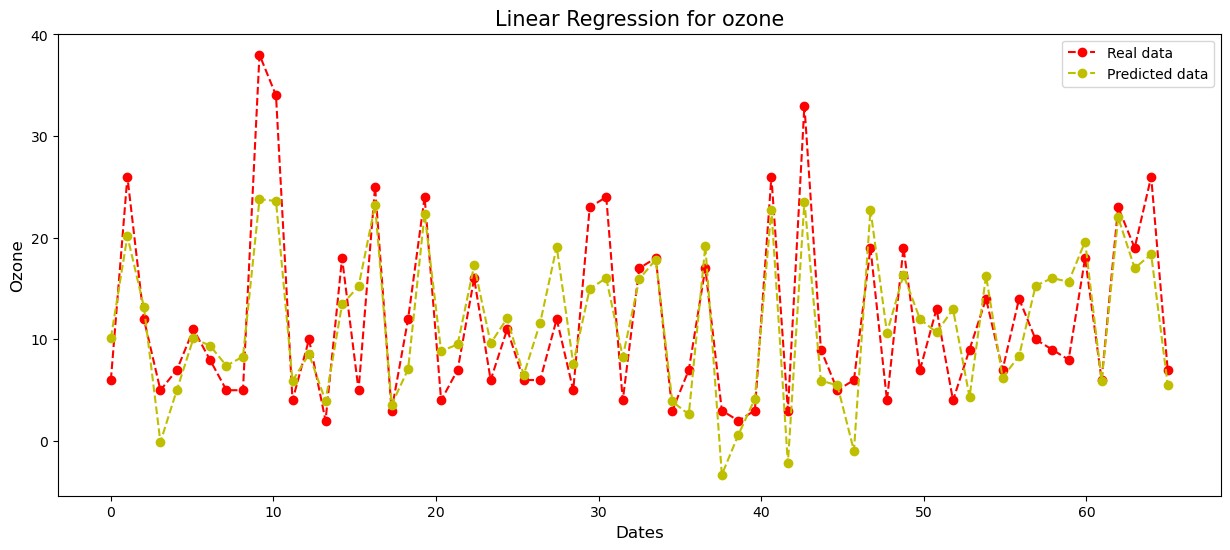

In [11]:
# Drawing the plot for linear regression
final_coeff_linear = np.insert(mean_coeff, 0, mean_intercept)
X_validation_1 = np.hstack([np.ones((X_validation.shape[0], 1)), X_validation])
plot_x = np.linspace(0,len(X_validation), len(X_validation))
y_pred_linear = np.dot(X_validation_1, final_coeff_linear)

fig = plt.figure(figsize = (15,6))
plt.plot(plot_x, y_validation, 'ro--', label = 'Real data')
plt.plot(plot_x, y_pred_linear, 'yo--', label = 'Predicted data')
plt.legend()
plt.xlabel('Dates', fontsize = 12)
plt.ylabel('Ozone', fontsize = 12)
plt.title('Linear Regression for ozone', fontsize = 15)

### 2.2 Lasso Regression with hyperparameter tuning

In [12]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV

# Define model evaluation method: split the data into 5 parts and take one part as training data(20%) in every iterations(5 iterations in total) / let random_state=integer to make sure outcome will be the same every time
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

# Define the range of alphas from 0.01 to 1.0 and check every 0.01
alphas = np.arange(0.01, 1.0, 0.01)

# Build up the Lasso regression model with alphas and cv defined above
model = LassoCV(alphas=alphas, cv=kf)

# Fit model
model.fit(X, y)

# Find R-square at the optimal alpha
lasso_r2 = r2_score(y_validation, model.predict(X_validation))

# Find RMSE at the optimal alpha
lasso_mse = mean_squared_error(y_validation, model.predict(X_validation))
lasso_rmse = np.sqrt(lasso_mse)

print('Optimal alpha: %f' % model.alpha_)
print(f'coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print(f'R-squared: {lasso_r2}')
print(f'RMSE: {lasso_rmse}')

Optimal alpha: 0.890000
coefficients: [ 0.          0.06480998  0.52127932 -0.0012048   0.00244976 -0.0068198 ]
Intercept: 3.224790786163526
R-squared: 0.6739219137487545
RMSE: 4.943264842522538


Text(0.5, 1.0, 'Lasso Regression for ozone')

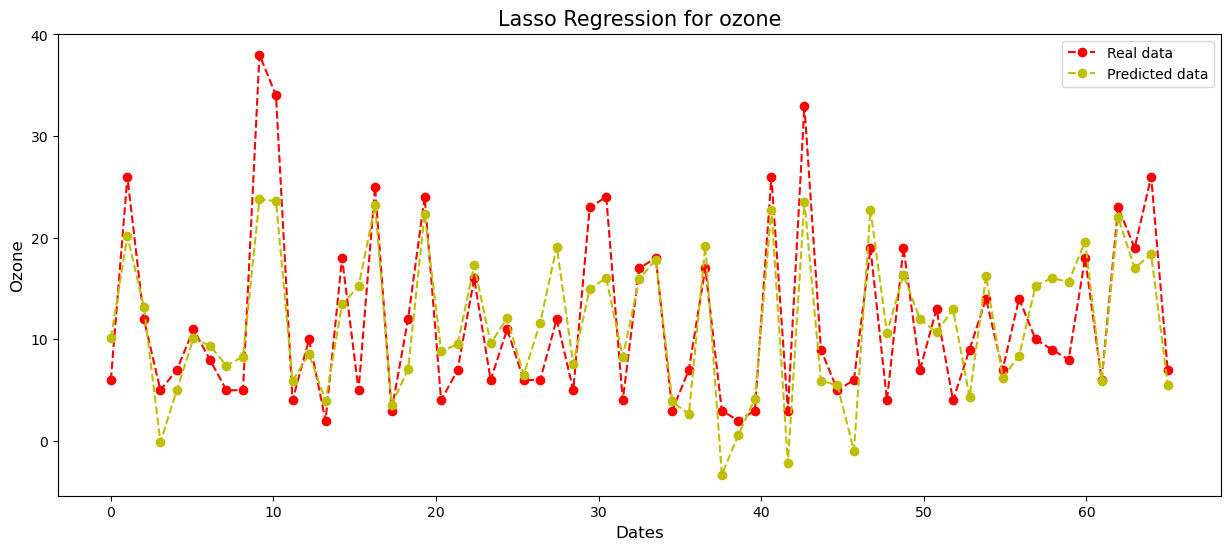

In [13]:
# Drawing the plot for lasso regression
final_coeff_lasso = np.insert(mean_coeff, 0, mean_intercept)
X_validation_1 = np.hstack([np.ones((X_validation.shape[0], 1)), X_validation])
plot_x = np.linspace(0,len(X_validation), len(X_validation))
y_pred_lasso = np.dot(X_validation_1, final_coeff_lasso)

fig = plt.figure(figsize = (15,6))
plt.plot(plot_x, y_validation, 'ro--', label = 'Real data')
plt.plot(plot_x, y_pred_lasso, 'yo--', label = 'Predicted data')
plt.legend()
plt.xlabel('Dates', fontsize = 12)
plt.ylabel('Ozone', fontsize = 12)
plt.title('Lasso Regression for ozone', fontsize = 15)

### 2.3 Ridge Regression with hyperparameter tuning

In [14]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
import numpy as np

# Define model evaluation method: split the data into 5 parts and take one part as training data(20%) in every iterations(5 iterations in total) / let random_state=integer to make sure outcome will be the same every time
#cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

# Define the range of alphas from 0.01 to 1.0 and check every 0.01
alphas = np.arange(0.01, 1.0, 0.01)

# Build up the Ridge regression model with alphas and cv defined above
model = RidgeCV(alphas=alphas, cv=kf)

# Fit model
model.fit(X, y)

# Find R-square at the optimal alpha
ridge_r2 = r2_score(y_validation, model.predict(X_validation))

# Find RMSE at the optimal alpha
ridge_mse = mean_squared_error(y_validation, model.predict(X_validation))
ridge_rmse = np.sqrt(ridge_mse)

print('Optimal alpha: %f' % model.alpha_)
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print(f'R-squared: {ridge_r2}')
print(f'RMSE: {ridge_rmse}')

Optimal alpha: 0.990000
Coefficients: [ 0.04348922  0.06624464  0.54227985 -0.00116367  0.00097347 -0.00658634]
Intercept: 2.4708711964074084
R-squared: 0.6815954177427688
RMSE: 4.8847543339644774


Text(0.5, 1.0, 'Ridge Regression for ozone')

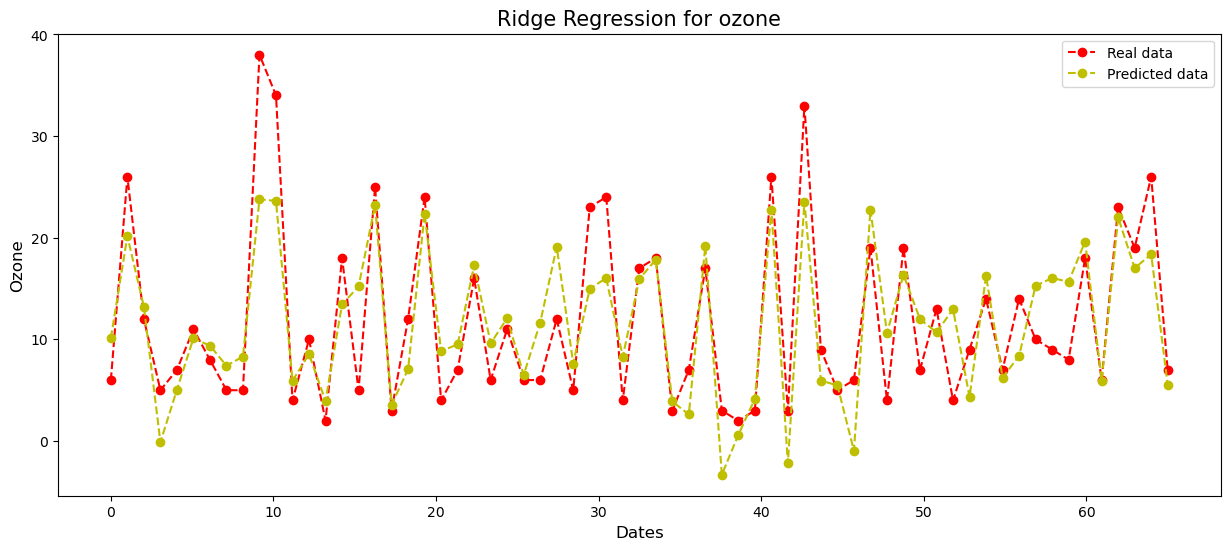

In [15]:
# Drawing the plot for ridge regression
final_coeff_ridge = np.insert(mean_coeff, 0, mean_intercept)
X_validation_1 = np.hstack([np.ones((X_validation.shape[0], 1)), X_validation])
plot_x = np.linspace(0,len(X_validation), len(X_validation))
y_pred_ridge = np.dot(X_validation_1, final_coeff_ridge)

fig = plt.figure(figsize = (15,6))
plt.plot(plot_x, y_validation, 'ro--', label = 'Real data')
plt.plot(plot_x, y_pred_ridge, 'yo--', label = 'Predicted data')
plt.legend()
plt.xlabel('Dates', fontsize = 12)
plt.ylabel('Ozone', fontsize = 12)
plt.title('Ridge Regression for ozone', fontsize = 15)

## 3. Model selection

In [16]:
# Choosing the best model with the largest r2
best_model_r2 = max([(linear_r2, 'Linear Regression'), (lasso_r2, 'Lasso Regression'), (ridge_r2, 'Ridge Regression')])
print(f"Best Model evaluating by r2: {best_model_r2[1]} with R-squared = {best_model_r2[0]}")

# Choosing the best model with the smallest root mean square error
best_model_rmse = min([(linear_rmse, 'Linear Regression'), (lasso_rmse, 'Lasso Regression'), (ridge_rmse, 'Ridge Regression')])
print(f"Best Model evaluating by RMSE: {best_model_rmse[1]} with RMSE = {best_model_rmse[0]}")

Best Model evaluating by r2: Ridge Regression with R-squared = 0.6815954177427688
Best Model evaluating by RMSE: Ridge Regression with RMSE = 4.8847543339644774


Text(0.5, 1.0, 'Comparing the predicted values for different regression')

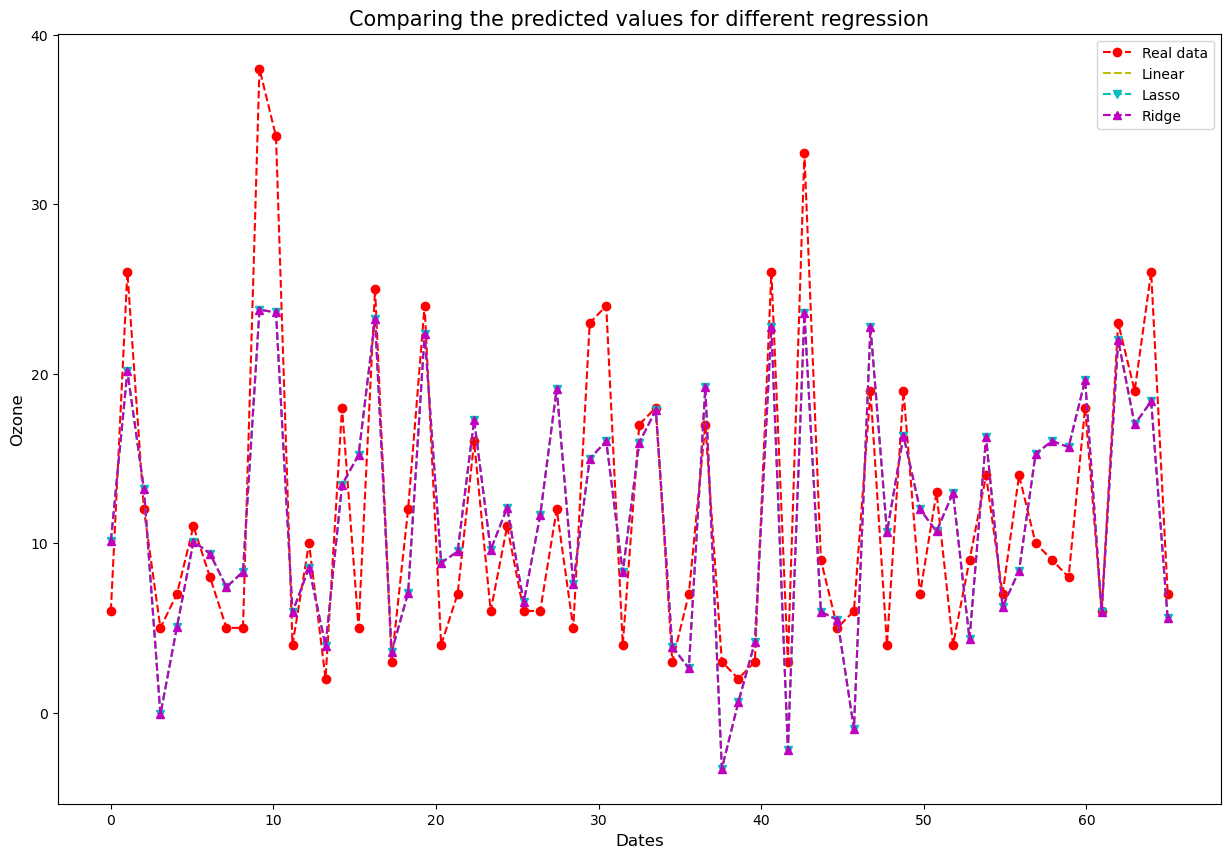

In [17]:
fig = plt.figure(figsize = (15,10))

plt.plot(plot_x, y_validation, 'ro--', label = 'Real data')
plt.plot(plot_x, y_pred_linear, 'y,--', label = 'Linear')
plt.plot(plot_x, y_pred_lasso, 'cv--', label = 'Lasso')
plt.plot(plot_x, y_pred_ridge, 'm^--', label = 'Ridge')
plt.legend()
plt.xlabel('Dates', fontsize = 12)
plt.ylabel('Ozone', fontsize = 12)
plt.title('Comparing the predicted values for different regression', fontsize = 15)
#plt.savefig(r'C:\지섭 Data 3\23-2\DEDA\model selection')